## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.5,0.2]
redice_lr_patient = [5,10,25]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.3098 - accuracy: 0.5453 - val_loss: 1.4813 - val_accuracy: 0.4834
Epoch 12/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2868 - accuracy: 0.5514 - val_loss: 1.4738 - val_accuracy: 0.4822
Epoch 13/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.2641 - accuracy: 0.5620 - val_loss: 1.4648 - val_accuracy: 0.4865
Epoch 14/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2435 - accuracy: 0.5692 - val_loss: 1.4720 - val_accuracy: 0.4852
Epoch 15/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.2246 - accuracy: 0.5751 - val_loss: 1.4628 - val_accuracy: 0.4884
Epoch 16/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.2023 - accuracy: 0.5830 - val_loss: 1.4459 - val_accuracy: 0.4948
Epoch 17/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.1827 - accuracy: 0.5915 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.2511 - accuracy: 0.2611 - val_loss: 2.1729 - val_accuracy: 0.1499
Epoch 2/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.7724 - accuracy: 0.3823 - val_loss: 2.0319 - val_accuracy: 0.2301
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.6395 - accuracy: 0.4278 - val_loss: 1.8463 - val_accuracy: 0.3504
Epoch 4/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.5654 - accuracy: 0.4521 - val_loss: 1.7230 - val_accuracy: 0.4086
Epoch 5/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5121 - accuracy: 0.4720 - val_loss: 1.6323 - val_accuracy: 0.4269
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4697 - accuracy: 0.4873 - val_loss: 1.6016 - val_accuracy: 0.4375
Epoch 7/25
50000/50000 [==============================] - 4s 88us/st

Epoch 21/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.1126 - accuracy: 0.6170 - val_loss: 1.4454 - val_accuracy: 0.4962
Epoch 22/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0966 - accuracy: 0.6231 - val_loss: 1.4417 - val_accuracy: 0.4929
Epoch 23/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0801 - accuracy: 0.6305 - val_loss: 1.4682 - val_accuracy: 0.4872
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0625 - accuracy: 0.6373 - val_loss: 1.4363 - val_accuracy: 0.4941
Epoch 25/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0458 - accuracy: 0.6434 - val_loss: 1.4509 - val_accuracy: 0.4927
Numbers of exp: 5, reduce_factor: 0.20, reduce_patient: 25
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.1673 - accuracy: 0.5897 - val_loss: 1.7624 - val_accuracy: 0.3894
Epoch 7/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1087 - accuracy: 0.6112 - val_loss: 1.8246 - val_accuracy: 0.3866
Epoch 8/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.0597 - accuracy: 0.6275 - val_loss: 1.6947 - val_accuracy: 0.4202
Epoch 9/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.0181 - accuracy: 0.6432 - val_loss: 1.6298 - val_accuracy: 0.4383
Epoch 10/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.9688 - accuracy: 0.6610 - val_loss: 1.7777 - val_accuracy: 0.4180
Epoch 11/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.9263 - accuracy: 0.6761 - val_loss: 1.7571 - val_accuracy: 0.4283
Epoch 12/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.8865 - accuracy: 0.6874 - val_loss

50000/50000 [==============================] - 5s 92us/step - loss: 0.6121 - accuracy: 0.8078 - val_loss: 1.5185 - val_accuracy: 0.5013
Epoch 25/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.5976 - accuracy: 0.8130 - val_loss: 1.5236 - val_accuracy: 0.5032
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 25
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
______________________________________________

Epoch 9/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.0988 - accuracy: 0.6197 - val_loss: 1.4705 - val_accuracy: 0.4817
Epoch 10/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0660 - accuracy: 0.6340 - val_loss: 1.4689 - val_accuracy: 0.4840
Epoch 11/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.0345 - accuracy: 0.6432 - val_loss: 1.4167 - val_accuracy: 0.5032
Epoch 12/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0008 - accuracy: 0.6577 - val_loss: 1.4428 - val_accuracy: 0.4940
Epoch 13/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.9739 - accuracy: 0.6676 - val_loss: 1.4578 - val_accuracy: 0.4868
Epoch 14/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.9433 - accuracy: 0.6788 - val_loss: 1.4152 - val_accuracy: 0.5012
Epoch 15/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.9176 - accuracy: 0.6886 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 107us/step - loss: 2.4567 - accuracy: 0.2033 - val_loss: 2.2212 - val_accuracy: 0.1620
Epoch 2/25
50000/50000 [==============================] - 5s 93us/step - loss: 2.0458 - accuracy: 0.3013 - val_loss: 2.1351 - val_accuracy: 0.2198
Epoch 3/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.9286 - accuracy: 0.3369 - val_loss: 2.0359 - val_accuracy: 0.2726
Epoch 4/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.8621 - accuracy: 0.3568 - val_loss: 1.9411 - val_accuracy: 0.3152
Epoch 5/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.8140 - accuracy: 0.3710 - val_loss: 1.8653 - val_accuracy: 0.3447
Epoch 6/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.7801 - accuracy: 0.3830 - val_loss: 1.8108 - val_accuracy: 0.3626
Epoch 7/25
50000/50000 [==============================] - 5s 93us/s

50000/50000 [==============================] - 5s 91us/step - loss: 0.5695 - accuracy: 0.8181 - val_loss: 1.4394 - val_accuracy: 0.5308
Epoch 21/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.5491 - accuracy: 0.8255 - val_loss: 1.4810 - val_accuracy: 0.5311
Epoch 22/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.5303 - accuracy: 0.8331 - val_loss: 1.4844 - val_accuracy: 0.5297
Epoch 23/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.5107 - accuracy: 0.8392 - val_loss: 1.4922 - val_accuracy: 0.5296
Epoch 24/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.4943 - accuracy: 0.8464 - val_loss: 1.5149 - val_accuracy: 0.5211

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.4553 - accuracy: 0.8652 - val_loss: 1.4872 - val_accuracy: 0.5339
Numbers of exp: 13, reduce_factor: 0.50, re

50000/50000 [==============================] - 5s 91us/step - loss: 1.4459 - accuracy: 0.4940 - val_loss: 1.6999 - val_accuracy: 0.3916
Epoch 5/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.3837 - accuracy: 0.5177 - val_loss: 1.5894 - val_accuracy: 0.4354
Epoch 6/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.3309 - accuracy: 0.5360 - val_loss: 1.5815 - val_accuracy: 0.4323
Epoch 7/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.2874 - accuracy: 0.5528 - val_loss: 1.5114 - val_accuracy: 0.4600
Epoch 8/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.2467 - accuracy: 0.5652 - val_loss: 1.4991 - val_accuracy: 0.4646
Epoch 9/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.2093 - accuracy: 0.5813 - val_loss: 1.4969 - val_accuracy: 0.4752
Epoch 10/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.1762 - accuracy: 0.5924 - val_loss: 1.6410 - va

50000/50000 [==============================] - 5s 98us/step - loss: 0.9515 - accuracy: 0.6838 - val_loss: 1.3882 - val_accuracy: 0.5196
Epoch 24/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.9500 - accuracy: 0.6833 - val_loss: 1.3879 - val_accuracy: 0.5208
Epoch 25/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.9490 - accuracy: 0.6837 - val_loss: 1.3880 - val_accuracy: 0.5192
Numbers of exp: 16, reduce_factor: 0.20, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
____________________________

Epoch 8/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.9980 - accuracy: 0.3188 - val_loss: 1.9410 - val_accuracy: 0.3182
Epoch 9/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.9601 - accuracy: 0.3309 - val_loss: 1.9218 - val_accuracy: 0.3273
Epoch 10/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.9262 - accuracy: 0.3395 - val_loss: 1.9087 - val_accuracy: 0.3355
Epoch 11/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.8964 - accuracy: 0.3486 - val_loss: 1.8934 - val_accuracy: 0.3411
Epoch 12/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.8697 - accuracy: 0.3565 - val_loss: 1.8826 - val_accuracy: 0.3470
Epoch 13/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.8461 - accuracy: 0.3635 - val_loss: 1.8700 - val_accuracy: 0.3526
Epoch 14/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.8243 - accuracy: 0.3716 - v

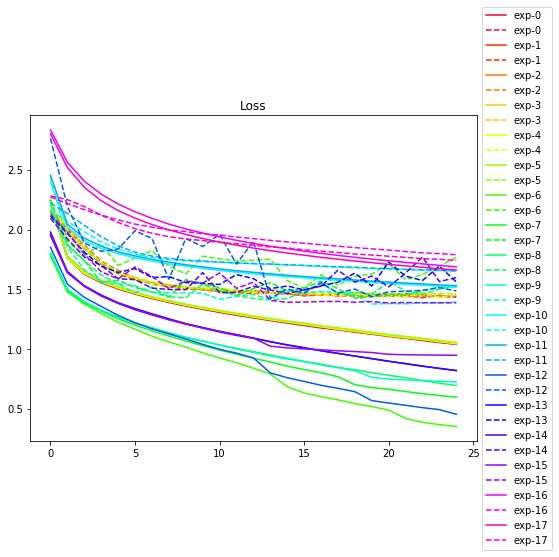

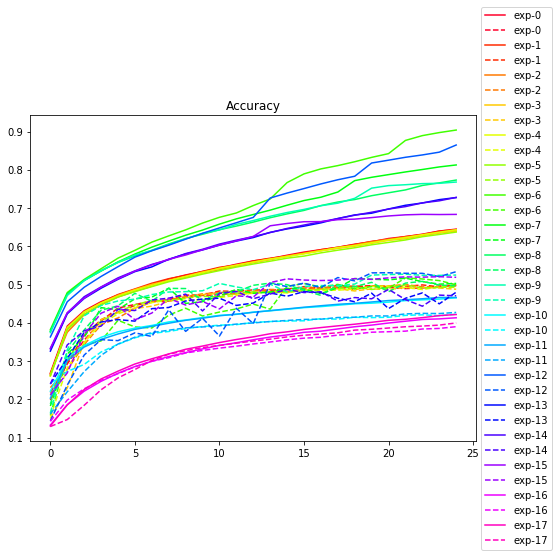

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()